In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime


%matplotlib inline
from RL_env.config import config
from RL_env.marketdata.yahoodownloader import YahooDownloader
from RL_env.preprocessing.preprocessors import FeatureEngineer
from RL_env.preprocessing.data import data_split
from RL_env.env.env_stocktrading import StockTradingEnv
from RL_env.model.models import DRLAgent,DRLEnsembleAgent
from RL_env.trade.backtest import backtest_stats, get_baseline, backtest_plot
from RL_env.trade.backtest import convert_daily_return_to_pyfolio_ts,get_daily_return


from pprint import pprint
from pyfolio import timeseries

import sys
sys.path.append("../FinRL-Library")

import itertools

In [2]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [3]:
start_date=config.START_DATE
end_date=config.END_DATE

In [4]:
df = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = config.PRO3_5_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (26420, 8)


In [5]:
# df.to_csv('susa.csv')

In [6]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,1.785156,1.800781,1.716797,1.464682,54070400.0,GILD,0
1,2000-01-03,48.031250,48.250000,47.031250,27.387001,2173400.0,MMM,0
2,2000-01-03,3.937500,3.968750,3.677083,3.585430,7522800.0,NVDA,0
3,2000-01-03,17.250000,17.562500,16.875000,8.298920,512400.0,SRE,0
4,2000-01-03,2.546875,2.562500,2.476563,1.997885,14484000.0,TJX,0


In [7]:
df.tail(10)

,date,open,high,low,close,volume,tic,day
26410,2020-12-30,57.000000,57.240002,56.560001,56.012474,8848800.0,GILD,2
26411,2020-12-30,173.880005,174.919998,173.380005,171.425491,1419100.0,MMM,2
26412,2020-12-30,519.609985,528.549988,515.869995,525.648560,5634900.0,NVDA,2
26413,2020-12-30,126.180000,127.089996,125.260002,124.751427,1312900.0,SRE,2
26414,2020-12-30,67.989998,68.769997,67.989998,67.796967,4476100.0,TJX,2
26415,2020-12-31,56.599998,58.360001,56.560001,57.604355,10870500.0,GILD,3
26416,2020-12-31,174.119995,174.869995,173.179993,172.095001,1841300.0,MMM,3
26417,2020-12-31,525.460022,526.039978,516.599976,522.019836,4810600.0,NVDA,3
26418,2020-12-31,125.910004,127.570000,125.010002,126.327927,948100.0,SRE,3
26419,2020-12-31,68.480003,68.589996,68.070000,67.787041,4563800.0,TJX,3


In [8]:
df.shape

(26420, 8)

In [9]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = True)

df = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added user defined features


In [10]:
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4
0,2000-01-03,1.785156,1.800781,1.716797,1.464682,54070400.0,GILD,0,0.0,1.525615,1.337099,0.0,-66.666667,100.0,1.464682,1.464682,17.698252,2.928430,-0.045505
5284,2000-01-03,48.031250,48.250000,47.031250,27.387001,2173400.0,MMM,0,0.0,1.525615,1.337099,0.0,-66.666667,100.0,27.387001,27.387001,17.698252,2.928430,-0.045505
10568,2000-01-03,3.937500,3.968750,3.677083,3.585430,7522800.0,NVDA,0,0.0,1.525615,1.337099,0.0,-66.666667,100.0,3.585430,3.585430,-0.869083,-2.033190,-0.045505
15852,2000-01-03,17.250000,17.562500,16.875000,8.298920,512400.0,SRE,0,0.0,1.525615,1.337099,0.0,-66.666667,100.0,8.298920,8.298920,1.314623,0.839247,-0.045505
21136,2000-01-03,2.546875,2.562500,2.476563,1.997885,14484000.0,TJX,0,0.0,1.525615,1.337099,0.0,-66.666667,100.0,1.997885,1.997885,-0.759260,-1.424036,-0.045505


In [11]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
    data_lookback = df.loc[i-lookback:i,:]
    price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
    return_lookback = price_lookback.pct_change().dropna()
    covs = return_lookback.cov().values 
    cov_list.append(covs)

df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [12]:
df.shape

(25160, 20)

In [13]:
df.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2001-01-02,2.609375,2.609375,2.289063,1.927983,38233600.0,GILD,1,-0.034864,2.452853,1.798626,45.962001,-28.639485,14.233922,2.063627,2.191394,-0.299249,-0.355602,-0.106255,"[[0.0036934898415591855, 0.0001951015174048590..."
1,2001-01-02,59.062500,60.750000,58.750000,35.466747,4651200.0,MMM,1,1.398066,36.389263,31.964683,66.844581,90.807296,39.231778,32.450938,30.025153,17.395778,2.912121,-0.010892,"[[0.0036934898415591855, 0.0001951015174048590..."
2,2001-01-02,5.500000,5.572917,4.968750,4.585903,7270200.0,NVDA,1,-0.911856,8.062424,3.948047,38.842012,-115.394679,38.866691,6.716657,8.333013,-0.870699,-2.045608,-0.086314,"[[0.0036934898415591855, 0.0001951015174048590..."
3,2001-01-02,23.000000,23.062500,22.250000,11.347570,577500.0,SRE,1,0.067166,12.377176,10.593007,52.391078,-40.367359,7.091459,11.651838,11.013639,1.474446,0.906017,-0.032257,"[[0.0036934898415591855, 0.0001951015174048590..."
4,2001-01-02,3.500000,3.570313,3.429688,2.720326,6704000.0,TJX,1,0.034033,2.950872,2.318753,54.598240,89.969486,28.712184,2.594534,2.570033,-0.760272,-1.428252,-0.011261,"[[0.0036934898415591855, 0.0001951015174048590..."
5,2001-01-03,2.314453,2.500000,2.085938,2.007638,42412800.0,GILD,2,-0.036482,2.450787,1.788174,47.353475,-62.619801,25.327082,2.069642,2.184702,-0.261987,-0.303793,0.041315,"[[0.0036899163273221894, 0.0001851911430220381..."
6,2001-01-03,59.000000,59.937500,58.187500,35.057598,4754400.0,MMM,2,1.332597,36.126766,32.608443,64.837104,76.409579,33.181906,32.673133,30.155043,16.462116,2.860034,-0.011536,"[[0.0036899163273221894, 0.0001851911430220381..."
7,2001-01-03,4.833333,6.572917,4.708333,5.993268,22759200.0,NVDA,2,-0.801494,7.970285,3.947319,44.315720,-72.280133,19.381343,6.592835,8.258177,-0.829045,-1.766356,0.306889,"[[0.0036899163273221894, 0.0001851911430220381..."
8,2001-01-03,22.625000,22.750000,21.937500,11.095398,1154900.0,SRE,2,0.028709,12.273043,10.587568,50.172586,-68.430503,13.342258,11.641297,11.030194,0.851310,0.615894,-0.022223,"[[0.0036899163273221894, 0.0001851911430220381..."
9,2001-01-03,3.437500,3.765625,3.421875,2.943405,14215200.0,TJX,2,0.055134,2.988066,2.302627,58.879190,139.254319,38.460517,2.607341,2.578351,-0.734718,-1.326963,0.082004,"[[0.0036899163273221894, 0.0001851911430220381..."


In [14]:
train = data_split(df, config.START_DATE,'2019-01-01')
trade = data_split(df, '2019-01-02', config.END_DATE)

In [15]:
train.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2001-01-02,2.609375,2.609375,2.289063,1.927983,38233600.0,GILD,1,-0.034864,2.452853,1.798626,45.962001,-28.639485,14.233922,2.063627,2.191394,-0.299249,-0.355602,-0.106255,"[[0.0036934898415591855, 0.0001951015174048590..."
0,2001-01-02,59.062500,60.750000,58.750000,35.466747,4651200.0,MMM,1,1.398066,36.389263,31.964683,66.844581,90.807296,39.231778,32.450938,30.025153,17.395778,2.912121,-0.010892,"[[0.0036934898415591855, 0.0001951015174048590..."
0,2001-01-02,5.500000,5.572917,4.968750,4.585903,7270200.0,NVDA,1,-0.911856,8.062424,3.948047,38.842012,-115.394679,38.866691,6.716657,8.333013,-0.870699,-2.045608,-0.086314,"[[0.0036934898415591855, 0.0001951015174048590..."
0,2001-01-02,23.000000,23.062500,22.250000,11.347570,577500.0,SRE,1,0.067166,12.377176,10.593007,52.391078,-40.367359,7.091459,11.651838,11.013639,1.474446,0.906017,-0.032257,"[[0.0036934898415591855, 0.0001951015174048590..."
0,2001-01-02,3.500000,3.570313,3.429688,2.720326,6704000.0,TJX,1,0.034033,2.950872,2.318753,54.598240,89.969486,28.712184,2.594534,2.570033,-0.760272,-1.428252,-0.011261,"[[0.0036934898415591855, 0.0001951015174048590..."
1,2001-01-03,2.314453,2.500000,2.085938,2.007638,42412800.0,GILD,2,-0.036482,2.450787,1.788174,47.353475,-62.619801,25.327082,2.069642,2.184702,-0.261987,-0.303793,0.041315,"[[0.0036899163273221894, 0.0001851911430220381..."
1,2001-01-03,59.000000,59.937500,58.187500,35.057598,4754400.0,MMM,2,1.332597,36.126766,32.608443,64.837104,76.409579,33.181906,32.673133,30.155043,16.462116,2.860034,-0.011536,"[[0.0036899163273221894, 0.0001851911430220381..."
1,2001-01-03,4.833333,6.572917,4.708333,5.993268,22759200.0,NVDA,2,-0.801494,7.970285,3.947319,44.315720,-72.280133,19.381343,6.592835,8.258177,-0.829045,-1.766356,0.306889,"[[0.0036899163273221894, 0.0001851911430220381..."
1,2001-01-03,22.625000,22.750000,21.937500,11.095398,1154900.0,SRE,2,0.028709,12.273043,10.587568,50.172586,-68.430503,13.342258,11.641297,11.030194,0.851310,0.615894,-0.022223,"[[0.0036899163273221894, 0.0001851911430220381..."
1,2001-01-03,3.437500,3.765625,3.421875,2.943405,14215200.0,TJX,2,0.055134,2.988066,2.302627,58.879190,139.254319,38.460517,2.607341,2.578351,-0.734718,-1.326963,0.082004,"[[0.0036899163273221894, 0.0001851911430220381..."


In [16]:
train.tail(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
4525,2018-12-28,62.810001,63.040001,61.669998,56.618069,6785400.0,GILD,4,-1.691374,65.924260,54.951140,38.831483,-143.913858,46.679962,60.918321,63.362666,0.327670,0.283425,-0.016841,"[[0.0003025204625314382, 0.0001313575781822813..."
4525,2018-12-28,191.809998,192.300003,188.570007,173.897583,2311400.0,MMM,4,-3.260699,194.582254,164.618167,45.210287,-91.689855,15.026458,181.306245,181.233824,2.071415,1.122138,-0.006974,"[[0.0003025204625314382, 0.0001313575781822813..."
4525,2018-12-28,132.000000,137.389999,130.309998,132.864899,15718200.0,NVDA,4,-12.772857,168.650559,121.318993,35.982557,-104.025497,36.016148,150.098604,187.851709,-0.235959,-0.269134,0.018907,"[[0.0003025204625314382, 0.0001313575781822813..."
4525,2018-12-28,107.169998,108.209999,106.699997,99.722450,2180000.0,SRE,4,-1.464479,111.529978,98.444645,41.567315,-179.131600,48.333514,104.712743,105.194444,-0.249445,-0.286942,0.005201,"[[0.0003025204625314382, 0.0001313575781822813..."
4525,2018-12-28,44.119999,44.450001,43.459999,42.615513,5045200.0,TJX,4,-1.746223,47.817767,39.947222,37.710801,-77.957378,27.370025,44.945855,48.980784,-0.572659,-0.850172,-0.000684,"[[0.0003025204625314382, 0.0001313575781822813..."
4526,2018-12-31,62.000000,63.070000,61.580002,57.231087,7584000.0,GILD,0,-1.668329,65.637368,54.638085,40.235449,-126.970868,47.103344,60.692329,63.121890,0.342964,0.294879,0.010827,"[[0.0003028489725019402, 0.0001316251765722092..."
4526,2018-12-31,190.339996,191.649994,188.500000,174.972015,1804400.0,MMM,0,-3.012638,193.547931,164.365040,45.978354,-82.717166,15.178812,181.117179,180.870232,2.057290,1.117529,0.006179,"[[0.0003028489725019402, 0.0001316251765722092..."
4526,2018-12-31,135.399994,136.710007,132.259995,132.715775,11628500.0,NVDA,0,-12.202283,167.425729,120.171839,35.949703,-102.241976,36.016148,147.994607,185.317626,-0.241503,-0.276416,-0.001122,"[[0.0003028489725019402, 0.0001316251765722092..."
4526,2018-12-31,107.570000,109.129997,106.540001,100.577728,1838000.0,SRE,0,-1.517092,111.643457,98.001803,43.179104,-144.872769,40.606737,104.600189,105.109588,-0.242157,-0.277279,0.008577,"[[0.0003028489725019402, 0.0001316251765722092..."
4526,2018-12-31,44.099998,44.860001,44.060001,43.520153,5582300.0,TJX,0,-1.560495,47.531955,39.965531,40.623526,-53.268504,21.754848,44.689702,48.814936,-0.567298,-0.837707,0.021228,"[[0.0003028489725019402, 0.0001316251765722092..."


In [17]:
trade.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2019-01-02,61.759998,64.010002,61.500000,58.045410,7839400.0,GILD,2,-1.566301,64.783223,54.769570,42.062845,-100.874673,35.123770,60.516769,62.931584,0.333759,0.288002,0.014229,"[[0.0003031735186632906, 0.0001317460446031033..."
0,2019-01-02,187.820007,190.990005,186.699997,175.348480,2475200.0,MMM,2,-2.753925,191.701464,164.653161,46.251462,-83.341168,19.162427,180.732408,180.542100,2.020885,1.105550,0.002152,"[[0.0003031735186632906, 0.0001317460446031033..."
0,2019-01-02,130.639999,138.479996,130.050003,135.419800,12718800.0,NVDA,2,-11.400489,164.625523,120.267033,37.028212,-93.420459,38.349565,145.808601,182.951759,-0.227710,-0.258396,0.020375,"[[0.0003031735186632906, 0.0001317460446031033..."
0,2019-01-02,107.980003,107.980003,106.089996,99.248322,1196500.0,SRE,2,-1.647074,111.694808,97.253062,41.345303,-158.874909,42.181516,104.498022,104.998427,-0.267106,-0.310755,-0.013218,"[[0.0003031735186632906, 0.0001317460446031033..."
0,2019-01-02,44.230000,45.040001,44.139999,43.442333,5939100.0,TJX,2,-1.403406,46.886579,40.203332,40.455181,-45.941107,19.286866,44.436467,48.648275,-0.562286,-0.826191,-0.001788,"[[0.0003031735186632906, 0.0001317460446031033..."
1,2019-01-03,66.290001,67.250000,65.139999,59.701500,14631300.0,GILD,3,-1.336405,64.080594,55.013138,45.564562,-13.944094,3.937108,60.413953,62.773718,0.374270,0.317923,0.028531,"[[0.0003017087940718006, 0.0001272593555289999..."
1,2019-01-03,188.279999,188.279999,182.889999,168.745956,3358200.0,MMM,3,-3.046543,189.581929,164.476959,42.365581,-120.839217,26.927445,180.003208,180.113807,1.826494,1.039037,-0.037654,"[[0.0003017087940718006, 0.0001272593555289999..."
1,2019-01-03,133.789993,135.160004,127.690002,127.238136,17638800.0,NVDA,3,-11.295051,159.677468,121.034789,35.174329,-118.663893,40.813503,144.606515,180.605618,-0.245978,-0.282334,-0.060417,"[[0.0003017087940718006, 0.0001272593555289999..."
1,2019-01-03,106.769997,107.980003,106.150002,99.703865,1289000.0,SRE,3,-1.693802,111.478195,96.704444,42.215239,-137.831313,42.181516,104.291499,104.874730,-0.216400,-0.243856,0.004590,"[[0.0003017087940718006, 0.0001272593555289999..."
1,2019-01-03,44.590000,44.869999,43.799999,42.985146,5887800.0,TJX,3,-1.300808,46.245814,40.435548,39.461333,-53.678455,22.460440,44.199768,48.473832,-0.568872,-0.841350,-0.010524,"[[0.0003017087940718006, 0.0001272593555289999..."


In [18]:
trade.tail(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
503,2020-12-30,57.000000,57.240002,56.560001,56.012474,8848800.0,GILD,2,-0.821451,61.135646,55.422033,37.606098,-158.298365,37.117314,58.538811,59.024953,-0.170053,-0.186394,-0.003167,"[[0.0005567576372497435, 0.0001951556528097459..."
503,2020-12-30,173.880005,174.919998,173.380005,171.425491,1419100.0,MMM,2,1.099464,174.519167,168.057107,54.741159,11.710515,8.677798,171.135715,166.768002,2.060488,1.118574,0.001495,"[[0.0005567576372497435, 0.0001951556528097459..."
503,2020-12-30,519.609985,528.549988,515.869995,525.648560,5634900.0,NVDA,2,-3.048772,546.629558,510.986384,50.295472,-67.229679,15.258158,529.444303,535.348430,2.066338,1.120484,0.015645,"[[0.0005567576372497435, 0.0001951556528097459..."
503,2020-12-30,126.180000,127.089996,125.260002,124.751427,1312900.0,SRE,2,-0.660721,130.460015,123.107396,48.415977,-116.580478,8.479832,127.427884,127.105461,-0.762671,-1.438310,-0.004510,"[[0.0005567576372497435, 0.0001951556528097459..."
503,2020-12-30,67.989998,68.769997,67.989998,67.796967,4476100.0,TJX,2,1.653243,68.186408,64.357153,62.235296,106.764115,45.753201,64.900786,60.414738,-0.456544,-0.609806,0.004559,"[[0.0005567576372497435, 0.0001951556528097459..."
504,2020-12-31,56.599998,58.360001,56.560001,57.604355,10870500.0,GILD,3,-0.727232,60.953325,55.388228,44.138214,-94.910966,11.922424,58.471983,58.966282,-0.150340,-0.162919,0.028420,"[[0.0005599288600243191, 0.0001952496561603180..."
504,2020-12-31,174.119995,174.869995,173.179993,172.095001,1841300.0,MMM,3,1.050215,174.526533,168.339208,55.439906,16.066508,7.377607,171.222333,166.996940,1.987535,1.094448,0.003906,"[[0.0005599288600243191, 0.0001952496561603180..."
504,2020-12-31,525.460022,526.039978,516.599976,522.019836,4810600.0,NVDA,3,-3.050796,544.860410,510.814205,49.525428,-81.517368,15.258158,528.960089,534.896957,2.033324,1.109659,-0.006903,"[[0.0005599288600243191, 0.0001952496561603180..."
504,2020-12-31,125.910004,127.570000,125.010002,126.327927,948100.0,SRE,3,-0.587280,130.126919,123.147373,50.291691,-90.611282,5.294020,127.243959,127.207408,-0.758002,-1.418824,0.012637,"[[0.0005599288600243191, 0.0001952496561603180..."
504,2020-12-31,68.480003,68.589996,68.070000,67.787041,4563800.0,TJX,3,1.612908,68.276751,64.593387,62.210031,103.657139,45.753201,65.137364,60.607971,-0.463404,-0.622510,-0.000146,"[[0.0005599288600243191, 0.0001952496561603180..."


In [19]:
from RL_env.env.env_portfolio import StockPortfolioEnv

In [20]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 5, State Space: 5


In [21]:
train.tic.unique()

array(['GILD', 'MMM', 'NVDA', 'SRE', 'TJX'], dtype=object)

In [22]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 100000, 
    "transaction_cost_pct": 0.0025, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "turbulence_threshold":330
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)


In [23]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [24]:
# initialize
agent = DRLAgent(env = env_train)

In [25]:
agent = DRLAgent(env = env_train)
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [26]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=500000)

Logging to tensorboard_log/a2c\a2c_22
-------------------------------------
| time/                 |           |
|    fps                | 172       |
|    iterations         | 100       |
|    time_elapsed       | 2         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -7.08     |
|    explained_variance | -4.41e-06 |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 2.88e+06  |
|    std                | 0.997     |
|    value_loss         | 1.95e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 263      |
|    iterations         | 200      |
|    time_elapsed       | 3        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -7.08    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates        

------------------------------------
| time/                 |          |
|    fps                | 483      |
|    iterations         | 1500     |
|    time_elapsed       | 15       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -6.99    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 1499     |
|    policy_loss        | 1.37e+07 |
|    std                | 0.98     |
|    value_loss         | 5.56e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 1600     |
|    time_elapsed       | 16       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -6.99    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 1599     |
|    policy_loss        | 3.04e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 509      |
|    iterations         | 2900     |
|    time_elapsed       | 28       |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -6.94    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 2899     |
|    policy_loss        | 4.52e+06 |
|    std                | 0.97     |
|    value_loss         | 4.23e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 511      |
|    iterations         | 3000     |
|    time_elapsed       | 29       |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -6.94    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 2999     |
|    policy_loss        | 7.19e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 521      |
|    iterations         | 4300     |
|    time_elapsed       | 41       |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -6.86    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 4299     |
|    policy_loss        | 3.66e+07 |
|    std                | 0.955    |
|    value_loss         | 3.53e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 521      |
|    iterations         | 4400     |
|    time_elapsed       | 42       |
|    total_timesteps    | 22000    |
| train/                |          |
|    entropy_loss       | -6.84    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 4399     |
|    policy_loss        | 6.79e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 527      |
|    iterations         | 5600     |
|    time_elapsed       | 53       |
|    total_timesteps    | 28000    |
| train/                |          |
|    entropy_loss       | -6.79    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 5599     |
|    policy_loss        | 6.27e+06 |
|    std                | 0.941    |
|    value_loss         | 6.64e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 528      |
|    iterations         | 5700     |
|    time_elapsed       | 53       |
|    total_timesteps    | 28500    |
| train/                |          |
|    entropy_loss       | -6.79    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 5699     |
|    policy_loss        | 7.34e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 531      |
|    iterations         | 7000     |
|    time_elapsed       | 65       |
|    total_timesteps    | 35000    |
| train/                |          |
|    entropy_loss       | -6.76    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 6999     |
|    policy_loss        | 2.76e+07 |
|    std                | 0.936    |
|    value_loss         | 2.77e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 532      |
|    iterations         | 7100     |
|    time_elapsed       | 66       |
|    total_timesteps    | 35500    |
| train/                |          |
|    entropy_loss       | -6.76    |
|    explained_variance | 2.38e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 7099     |
|    policy_loss        | 4.92e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 533      |
|    iterations         | 8300     |
|    time_elapsed       | 77       |
|    total_timesteps    | 41500    |
| train/                |          |
|    entropy_loss       | -6.71    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 8299     |
|    policy_loss        | 4.64e+06 |
|    std                | 0.927    |
|    value_loss         | 5.62e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 533      |
|    iterations         | 8400     |
|    time_elapsed       | 78       |
|    total_timesteps    | 42000    |
| train/                |          |
|    entropy_loss       | -6.7     |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 8399     |
|    policy_loss        | 6.53e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 535      |
|    iterations         | 9700     |
|    time_elapsed       | 90       |
|    total_timesteps    | 48500    |
| train/                |          |
|    entropy_loss       | -6.64    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 9699     |
|    policy_loss        | 2.32e+07 |
|    std                | 0.913    |
|    value_loss         | 1.91e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 535      |
|    iterations         | 9800     |
|    time_elapsed       | 91       |
|    total_timesteps    | 49000    |
| train/                |          |
|    entropy_loss       | -6.63    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 9799     |
|    policy_loss        | 3.85e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 535      |
|    iterations         | 11000    |
|    time_elapsed       | 102      |
|    total_timesteps    | 55000    |
| train/                |          |
|    entropy_loss       | -6.56    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 10999    |
|    policy_loss        | 3.36e+06 |
|    std                | 0.899    |
|    value_loss         | 3.48e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 535       |
|    iterations         | 11100     |
|    time_elapsed       | 103       |
|    total_timesteps    | 55500     |
| train/                |           |
|    entropy_loss       | -6.56     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 11099     |
|    policy_loss        | 5

------------------------------------
| time/                 |          |
|    fps                | 537      |
|    iterations         | 12400    |
|    time_elapsed       | 115      |
|    total_timesteps    | 62000    |
| train/                |          |
|    entropy_loss       | -6.48    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 12399    |
|    policy_loss        | 2.18e+07 |
|    std                | 0.885    |
|    value_loss         | 1.45e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 537      |
|    iterations         | 12500    |
|    time_elapsed       | 116      |
|    total_timesteps    | 62500    |
| train/                |          |
|    entropy_loss       | -6.48    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 12499    |
|    policy_loss        | 3.53e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 537      |
|    iterations         | 13700    |
|    time_elapsed       | 127      |
|    total_timesteps    | 68500    |
| train/                |          |
|    entropy_loss       | -6.42    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 13699    |
|    policy_loss        | 4.01e+06 |
|    std                | 0.874    |
|    value_loss         | 5.31e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 537       |
|    iterations         | 13800     |
|    time_elapsed       | 128       |
|    total_timesteps    | 69000     |
| train/                |           |
|    entropy_loss       | -6.4      |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 13799     |
|    policy_loss        | 7

------------------------------------
| time/                 |          |
|    fps                | 539      |
|    iterations         | 15100    |
|    time_elapsed       | 140      |
|    total_timesteps    | 75500    |
| train/                |          |
|    entropy_loss       | -6.34    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 15099    |
|    policy_loss        | 2.12e+07 |
|    std                | 0.86     |
|    value_loss         | 1.65e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 539      |
|    iterations         | 15200    |
|    time_elapsed       | 140      |
|    total_timesteps    | 76000    |
| train/                |          |
|    entropy_loss       | -6.33    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 15199    |
|    policy_loss        | 3.88e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 539      |
|    iterations         | 16400    |
|    time_elapsed       | 152      |
|    total_timesteps    | 82000    |
| train/                |          |
|    entropy_loss       | -6.28    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 16399    |
|    policy_loss        | 3.16e+06 |
|    std                | 0.85     |
|    value_loss         | 3.34e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 539       |
|    iterations         | 16500     |
|    time_elapsed       | 152       |
|    total_timesteps    | 82500     |
| train/                |           |
|    entropy_loss       | -6.28     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 16499     |
|    policy_loss        | 4

------------------------------------
| time/                 |          |
|    fps                | 540      |
|    iterations         | 17800    |
|    time_elapsed       | 164      |
|    total_timesteps    | 89000    |
| train/                |          |
|    entropy_loss       | -6.23    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 17799    |
|    policy_loss        | 1.2e+07  |
|    std                | 0.842    |
|    value_loss         | 3.47e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 540      |
|    iterations         | 17900    |
|    time_elapsed       | 165      |
|    total_timesteps    | 89500    |
| train/                |          |
|    entropy_loss       | -6.22    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 17899    |
|    policy_loss        | 2.28e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 540       |
|    iterations         | 19200     |
|    time_elapsed       | 177       |
|    total_timesteps    | 96000     |
| train/                |           |
|    entropy_loss       | -6.18     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 19199     |
|    policy_loss        | 5.44e+06  |
|    std                | 0.834     |
|    value_loss         | 7.31e+11  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 540       |
|    iterations         | 19300     |
|    time_elapsed       | 178       |
|    total_timesteps    | 96500     |
| train/                |           |
|    entropy_loss       | -6.18     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 19299     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 539      |
|    iterations         | 20600    |
|    time_elapsed       | 190      |
|    total_timesteps    | 103000   |
| train/                |          |
|    entropy_loss       | -6.1     |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 20599    |
|    policy_loss        | 3.88e+07 |
|    std                | 0.821    |
|    value_loss         | 4.58e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 539      |
|    iterations         | 20700    |
|    time_elapsed       | 191      |
|    total_timesteps    | 103500   |
| train/                |          |
|    entropy_loss       | -6.1     |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 20699    |
|    policy_loss        | 5.51e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 539      |
|    iterations         | 21900    |
|    time_elapsed       | 202      |
|    total_timesteps    | 109500   |
| train/                |          |
|    entropy_loss       | -6.04    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 21899    |
|    policy_loss        | 3.81e+06 |
|    std                | 0.811    |
|    value_loss         | 5.81e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 540      |
|    iterations         | 22000    |
|    time_elapsed       | 203      |
|    total_timesteps    | 110000   |
| train/                |          |
|    entropy_loss       | -6.03    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 21999    |
|    policy_loss        | 8.13e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 540      |
|    iterations         | 23300    |
|    time_elapsed       | 215      |
|    total_timesteps    | 116500   |
| train/                |          |
|    entropy_loss       | -5.96    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 23299    |
|    policy_loss        | 2.44e+07 |
|    std                | 0.798    |
|    value_loss         | 2.43e+13 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 540       |
|    iterations         | 23400     |
|    time_elapsed       | 216       |
|    total_timesteps    | 117000    |
| train/                |           |
|    entropy_loss       | -5.95     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 23399     |
|    policy_loss        | 3

------------------------------------
| time/                 |          |
|    fps                | 541      |
|    iterations         | 24600    |
|    time_elapsed       | 227      |
|    total_timesteps    | 123000   |
| train/                |          |
|    entropy_loss       | -5.89    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 24599    |
|    policy_loss        | 4.49e+06 |
|    std                | 0.787    |
|    value_loss         | 7.64e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 541      |
|    iterations         | 24700    |
|    time_elapsed       | 228      |
|    total_timesteps    | 123500   |
| train/                |          |
|    entropy_loss       | -5.88    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 24699    |
|    policy_loss        | 8.25e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 541      |
|    iterations         | 26000    |
|    time_elapsed       | 240      |
|    total_timesteps    | 130000   |
| train/                |          |
|    entropy_loss       | -5.81    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 25999    |
|    policy_loss        | 2.22e+07 |
|    std                | 0.776    |
|    value_loss         | 2.08e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 541      |
|    iterations         | 26100    |
|    time_elapsed       | 240      |
|    total_timesteps    | 130500   |
| train/                |          |
|    entropy_loss       | -5.81    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 26099    |
|    policy_loss        | 3.02e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 541      |
|    iterations         | 27300    |
|    time_elapsed       | 252      |
|    total_timesteps    | 136500   |
| train/                |          |
|    entropy_loss       | -5.74    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 27299    |
|    policy_loss        | 3.9e+06  |
|    std                | 0.764    |
|    value_loss         | 6.84e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 541       |
|    iterations         | 27400     |
|    time_elapsed       | 253       |
|    total_timesteps    | 137000    |
| train/                |           |
|    entropy_loss       | -5.73     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 27399     |
|    policy_loss        | 6

------------------------------------
| time/                 |          |
|    fps                | 541      |
|    iterations         | 28700    |
|    time_elapsed       | 264      |
|    total_timesteps    | 143500   |
| train/                |          |
|    entropy_loss       | -5.65    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 28699    |
|    policy_loss        | 2.55e+07 |
|    std                | 0.751    |
|    value_loss         | 2.94e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 541      |
|    iterations         | 28800    |
|    time_elapsed       | 265      |
|    total_timesteps    | 144000   |
| train/                |          |
|    entropy_loss       | -5.64    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 28799    |
|    policy_loss        | 4.35e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 541      |
|    iterations         | 30000    |
|    time_elapsed       | 276      |
|    total_timesteps    | 150000   |
| train/                |          |
|    entropy_loss       | -5.58    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 29999    |
|    policy_loss        | 3.86e+06 |
|    std                | 0.74     |
|    value_loss         | 4.88e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 541      |
|    iterations         | 30100    |
|    time_elapsed       | 277      |
|    total_timesteps    | 150500   |
| train/                |          |
|    entropy_loss       | -5.57    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 30099    |
|    policy_loss        | 4.46e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 542       |
|    iterations         | 31400     |
|    time_elapsed       | 289       |
|    total_timesteps    | 157000    |
| train/                |           |
|    entropy_loss       | -5.5      |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 31399     |
|    policy_loss        | 1.94e+07  |
|    std                | 0.729     |
|    value_loss         | 1.63e+13  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 542      |
|    iterations         | 31500    |
|    time_elapsed       | 290      |
|    total_timesteps    | 157500   |
| train/                |          |
|    entropy_loss       | -5.49    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 31499    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 542      |
|    iterations         | 32700    |
|    time_elapsed       | 301      |
|    total_timesteps    | 163500   |
| train/                |          |
|    entropy_loss       | -5.41    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 32699    |
|    policy_loss        | 2.19e+06 |
|    std                | 0.717    |
|    value_loss         | 3.11e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 542       |
|    iterations         | 32800     |
|    time_elapsed       | 302       |
|    total_timesteps    | 164000    |
| train/                |           |
|    entropy_loss       | -5.41     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 32799     |
|    policy_loss        | 5

------------------------------------
| time/                 |          |
|    fps                | 542      |
|    iterations         | 34100    |
|    time_elapsed       | 314      |
|    total_timesteps    | 170500   |
| train/                |          |
|    entropy_loss       | -5.32    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 34099    |
|    policy_loss        | 1.61e+07 |
|    std                | 0.703    |
|    value_loss         | 1.55e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 542      |
|    iterations         | 34200    |
|    time_elapsed       | 315      |
|    total_timesteps    | 171000   |
| train/                |          |
|    entropy_loss       | -5.31    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 34199    |
|    policy_loss        | 3.99e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 542       |
|    iterations         | 35500     |
|    time_elapsed       | 326       |
|    total_timesteps    | 177500    |
| train/                |           |
|    entropy_loss       | -5.21     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 35499     |
|    policy_loss        | 3.86e+06  |
|    std                | 0.688     |
|    value_loss         | 7.73e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 542      |
|    iterations         | 35600    |
|    time_elapsed       | 327      |
|    total_timesteps    | 178000   |
| train/                |          |
|    entropy_loss       | -5.2     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 35599    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 36900    |
|    time_elapsed       | 339      |
|    total_timesteps    | 184500   |
| train/                |          |
|    entropy_loss       | -5.12    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 36899    |
|    policy_loss        | 2.62e+07 |
|    std                | 0.677    |
|    value_loss         | 2.56e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 37000    |
|    time_elapsed       | 340      |
|    total_timesteps    | 185000   |
| train/                |          |
|    entropy_loss       | -5.12    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 36999    |
|    policy_loss        | 3.3e+07  |
|

-------------------------------------
| time/                 |           |
|    fps                | 543       |
|    iterations         | 38200     |
|    time_elapsed       | 351       |
|    total_timesteps    | 191000    |
| train/                |           |
|    entropy_loss       | -5.07     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 38199     |
|    policy_loss        | 4.49e+06  |
|    std                | 0.67      |
|    value_loss         | 1.08e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 38300    |
|    time_elapsed       | 352      |
|    total_timesteps    | 191500   |
| train/                |          |
|    entropy_loss       | -5.06    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 38299    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 543       |
|    iterations         | 39600     |
|    time_elapsed       | 364       |
|    total_timesteps    | 198000    |
| train/                |           |
|    entropy_loss       | -4.96     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 39599     |
|    policy_loss        | 2.33e+07  |
|    std                | 0.656     |
|    value_loss         | 4.32e+13  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 39700    |
|    time_elapsed       | 365      |
|    total_timesteps    | 198500   |
| train/                |          |
|    entropy_loss       | -4.95    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 39699    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 40900    |
|    time_elapsed       | 376      |
|    total_timesteps    | 204500   |
| train/                |          |
|    entropy_loss       | -4.87    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 40899    |
|    policy_loss        | 3.41e+06 |
|    std                | 0.645    |
|    value_loss         | 8.5e+11  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 41000    |
|    time_elapsed       | 377      |
|    total_timesteps    | 205000   |
| train/                |          |
|    entropy_loss       | -4.86    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 40999    |
|    policy_loss        | 5.76e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 42300    |
|    time_elapsed       | 389      |
|    total_timesteps    | 211500   |
| train/                |          |
|    entropy_loss       | -4.76    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 42299    |
|    policy_loss        | 2.2e+07  |
|    std                | 0.63     |
|    value_loss         | 2.4e+13  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 42400    |
|    time_elapsed       | 390      |
|    total_timesteps    | 212000   |
| train/                |          |
|    entropy_loss       | -4.75    |
|    explained_variance | 2.38e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 42399    |
|    policy_loss        | 3.14e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 542      |
|    iterations         | 43600    |
|    time_elapsed       | 401      |
|    total_timesteps    | 218000   |
| train/                |          |
|    entropy_loss       | -4.65    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 43599    |
|    policy_loss        | 2.69e+06 |
|    std                | 0.617    |
|    value_loss         | 6.13e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 542      |
|    iterations         | 43700    |
|    time_elapsed       | 402      |
|    total_timesteps    | 218500   |
| train/                |          |
|    entropy_loss       | -4.66    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 43699    |
|    policy_loss        | 5.41e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 45000    |
|    time_elapsed       | 414      |
|    total_timesteps    | 225000   |
| train/                |          |
|    entropy_loss       | -4.57    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 44999    |
|    policy_loss        | 2.08e+07 |
|    std                | 0.607    |
|    value_loss         | 2.41e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 45100    |
|    time_elapsed       | 415      |
|    total_timesteps    | 225500   |
| train/                |          |
|    entropy_loss       | -4.57    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 45099    |
|    policy_loss        | 3.28e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 542      |
|    iterations         | 46300    |
|    time_elapsed       | 426      |
|    total_timesteps    | 231500   |
| train/                |          |
|    entropy_loss       | -4.5     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 46299    |
|    policy_loss        | 2.29e+06 |
|    std                | 0.599    |
|    value_loss         | 4.02e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 46400    |
|    time_elapsed       | 427      |
|    total_timesteps    | 232000   |
| train/                |          |
|    entropy_loss       | -4.49    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 46399    |
|    policy_loss        | 4.96e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 543       |
|    iterations         | 47700     |
|    time_elapsed       | 439       |
|    total_timesteps    | 238500    |
| train/                |           |
|    entropy_loss       | -4.41     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 47699     |
|    policy_loss        | 2.05e+07  |
|    std                | 0.588     |
|    value_loss         | 2.44e+13  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 47800    |
|    time_elapsed       | 439      |
|    total_timesteps    | 239000   |
| train/                |          |
|    entropy_loss       | -4.4     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 47799    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 49000    |
|    time_elapsed       | 450      |
|    total_timesteps    | 245000   |
| train/                |          |
|    entropy_loss       | -4.32    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 48999    |
|    policy_loss        | 1.63e+06 |
|    std                | 0.579    |
|    value_loss         | 2.96e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 49100    |
|    time_elapsed       | 451      |
|    total_timesteps    | 245500   |
| train/                |          |
|    entropy_loss       | -4.32    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 49099    |
|    policy_loss        | 3.09e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 50400    |
|    time_elapsed       | 463      |
|    total_timesteps    | 252000   |
| train/                |          |
|    entropy_loss       | -4.26    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 50399    |
|    policy_loss        | 9.95e+06 |
|    std                | 0.572    |
|    value_loss         | 7.98e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 543       |
|    iterations         | 50500     |
|    time_elapsed       | 464       |
|    total_timesteps    | 252500    |
| train/                |           |
|    entropy_loss       | -4.24     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 50499     |
|    policy_loss        | 2

-------------------------------------
| time/                 |           |
|    fps                | 543       |
|    iterations         | 51800     |
|    time_elapsed       | 476       |
|    total_timesteps    | 259000    |
| train/                |           |
|    entropy_loss       | -4.15     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 51799     |
|    policy_loss        | 3.81e+06  |
|    std                | 0.56      |
|    value_loss         | 6.94e+11  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 543       |
|    iterations         | 51900     |
|    time_elapsed       | 477       |
|    total_timesteps    | 259500    |
| train/                |           |
|    entropy_loss       | -4.14     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 51899     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 53200    |
|    time_elapsed       | 489      |
|    total_timesteps    | 266000   |
| train/                |          |
|    entropy_loss       | -4.02    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 53199    |
|    policy_loss        | 2.55e+07 |
|    std                | 0.545    |
|    value_loss         | 3.3e+13  |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 543       |
|    iterations         | 53300     |
|    time_elapsed       | 490       |
|    total_timesteps    | 266500    |
| train/                |           |
|    entropy_loss       | -4.01     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 53299     |
|    policy_loss        | 2

-------------------------------------
| time/                 |           |
|    fps                | 543       |
|    iterations         | 54500     |
|    time_elapsed       | 501       |
|    total_timesteps    | 272500    |
| train/                |           |
|    entropy_loss       | -3.92     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 54499     |
|    policy_loss        | 3.5e+06   |
|    std                | 0.535     |
|    value_loss         | 9.08e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 54600    |
|    time_elapsed       | 502      |
|    total_timesteps    | 273000   |
| train/                |          |
|    entropy_loss       | -3.91    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 54599    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 55900    |
|    time_elapsed       | 514      |
|    total_timesteps    | 279500   |
| train/                |          |
|    entropy_loss       | -3.84    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 55899    |
|    policy_loss        | 1.59e+07 |
|    std                | 0.527    |
|    value_loss         | 3.31e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 56000    |
|    time_elapsed       | 514      |
|    total_timesteps    | 280000   |
| train/                |          |
|    entropy_loss       | -3.84    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 55999    |
|    policy_loss        | 3.81e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 543       |
|    iterations         | 57200     |
|    time_elapsed       | 526       |
|    total_timesteps    | 286000    |
| train/                |           |
|    entropy_loss       | -3.75     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 57199     |
|    policy_loss        | 3.21e+06  |
|    std                | 0.519     |
|    value_loss         | 8.99e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 57300    |
|    time_elapsed       | 526      |
|    total_timesteps    | 286500   |
| train/                |          |
|    entropy_loss       | -3.75    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 57299    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 58600    |
|    time_elapsed       | 538      |
|    total_timesteps    | 293000   |
| train/                |          |
|    entropy_loss       | -3.69    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 58599    |
|    policy_loss        | 1.85e+07 |
|    std                | 0.513    |
|    value_loss         | 2.98e+13 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 543       |
|    iterations         | 58700     |
|    time_elapsed       | 539       |
|    total_timesteps    | 293500    |
| train/                |           |
|    entropy_loss       | -3.68     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 58699     |
|    policy_loss        | 3

------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 59900    |
|    time_elapsed       | 550      |
|    total_timesteps    | 299500   |
| train/                |          |
|    entropy_loss       | -3.61    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 59899    |
|    policy_loss        | 2.51e+06 |
|    std                | 0.505    |
|    value_loss         | 5.19e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 60000    |
|    time_elapsed       | 551      |
|    total_timesteps    | 300000   |
| train/                |          |
|    entropy_loss       | -3.61    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 59999    |
|    policy_loss        | 3.43e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 544       |
|    iterations         | 61300     |
|    time_elapsed       | 563       |
|    total_timesteps    | 306500    |
| train/                |           |
|    entropy_loss       | -3.54     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 61299     |
|    policy_loss        | 1.8e+07   |
|    std                | 0.498     |
|    value_loss         | 1.54e+13  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 61400    |
|    time_elapsed       | 564      |
|    total_timesteps    | 307000   |
| train/                |          |
|    entropy_loss       | -3.53    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 61399    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 544       |
|    iterations         | 62600     |
|    time_elapsed       | 575       |
|    total_timesteps    | 313000    |
| train/                |           |
|    entropy_loss       | -3.46     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 62599     |
|    policy_loss        | 1.75e+06  |
|    std                | 0.491     |
|    value_loss         | 6.4e+11   |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 62700    |
|    time_elapsed       | 576      |
|    total_timesteps    | 313500   |
| train/                |          |
|    entropy_loss       | -3.46    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 62699    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 544       |
|    iterations         | 64000     |
|    time_elapsed       | 588       |
|    total_timesteps    | 320000    |
| train/                |           |
|    entropy_loss       | -3.37     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 63999     |
|    policy_loss        | 1.13e+07  |
|    std                | 0.482     |
|    value_loss         | 1.49e+13  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 64100    |
|    time_elapsed       | 588      |
|    total_timesteps    | 320500   |
| train/                |          |
|    entropy_loss       | -3.37    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 64099    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 65300    |
|    time_elapsed       | 599      |
|    total_timesteps    | 326500   |
| train/                |          |
|    entropy_loss       | -3.27    |
|    explained_variance | 2.98e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 65299    |
|    policy_loss        | 1.49e+06 |
|    std                | 0.473    |
|    value_loss         | 3.37e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 65400    |
|    time_elapsed       | 600      |
|    total_timesteps    | 327000   |
| train/                |          |
|    entropy_loss       | -3.26    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 65399    |
|    policy_loss        | 2.9e+06  |
|

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 66700    |
|    time_elapsed       | 612      |
|    total_timesteps    | 333500   |
| train/                |          |
|    entropy_loss       | -3.14    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 66699    |
|    policy_loss        | 1.12e+07 |
|    std                | 0.462    |
|    value_loss         | 1.07e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 66800    |
|    time_elapsed       | 613      |
|    total_timesteps    | 334000   |
| train/                |          |
|    entropy_loss       | -3.14    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 66799    |
|    policy_loss        | 1.89e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 544       |
|    iterations         | 68100     |
|    time_elapsed       | 625       |
|    total_timesteps    | 340500    |
| train/                |           |
|    entropy_loss       | -3.06     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 68099     |
|    policy_loss        | 2.49e+06  |
|    std                | 0.455     |
|    value_loss         | 7.43e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 68200    |
|    time_elapsed       | 626      |
|    total_timesteps    | 341000   |
| train/                |          |
|    entropy_loss       | -3.04    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 68199    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 69500    |
|    time_elapsed       | 638      |
|    total_timesteps    | 347500   |
| train/                |          |
|    entropy_loss       | -2.96    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 69499    |
|    policy_loss        | 1.19e+07 |
|    std                | 0.447    |
|    value_loss         | 4.24e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 69600    |
|    time_elapsed       | 639      |
|    total_timesteps    | 348000   |
| train/                |          |
|    entropy_loss       | -2.94    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 69599    |
|    policy_loss        | 2.51e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 70800    |
|    time_elapsed       | 650      |
|    total_timesteps    | 354000   |
| train/                |          |
|    entropy_loss       | -2.89    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 70799    |
|    policy_loss        | 1.48e+06 |
|    std                | 0.441    |
|    value_loss         | 5.24e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 544       |
|    iterations         | 70900     |
|    time_elapsed       | 651       |
|    total_timesteps    | 354500    |
| train/                |           |
|    entropy_loss       | -2.88     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 70899     |
|    policy_loss        | 3

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 72200    |
|    time_elapsed       | 663      |
|    total_timesteps    | 361000   |
| train/                |          |
|    entropy_loss       | -2.77    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 72199    |
|    policy_loss        | 1.24e+07 |
|    std                | 0.432    |
|    value_loss         | 1.77e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 72300    |
|    time_elapsed       | 663      |
|    total_timesteps    | 361500   |
| train/                |          |
|    entropy_loss       | -2.76    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 72299    |
|    policy_loss        | 9.2e+06  |
|

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 73500    |
|    time_elapsed       | 674      |
|    total_timesteps    | 367500   |
| train/                |          |
|    entropy_loss       | -2.66    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 73499    |
|    policy_loss        | 1.32e+06 |
|    std                | 0.423    |
|    value_loss         | 5.49e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 544       |
|    iterations         | 73600     |
|    time_elapsed       | 675       |
|    total_timesteps    | 368000    |
| train/                |           |
|    entropy_loss       | -2.65     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 73599     |
|    policy_loss        | 2

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 74900    |
|    time_elapsed       | 687      |
|    total_timesteps    | 374500   |
| train/                |          |
|    entropy_loss       | -2.55    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 74899    |
|    policy_loss        | 9.82e+06 |
|    std                | 0.415    |
|    value_loss         | 2.54e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 75000    |
|    time_elapsed       | 688      |
|    total_timesteps    | 375000   |
| train/                |          |
|    entropy_loss       | -2.55    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 74999    |
|    policy_loss        | 1.13e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 76200    |
|    time_elapsed       | 699      |
|    total_timesteps    | 381000   |
| train/                |          |
|    entropy_loss       | -2.45    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 76199    |
|    policy_loss        | 1.23e+06 |
|    std                | 0.407    |
|    value_loss         | 4.83e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 76300    |
|    time_elapsed       | 700      |
|    total_timesteps    | 381500   |
| train/                |          |
|    entropy_loss       | -2.45    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 76299    |
|    policy_loss        | 2.92e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 77600    |
|    time_elapsed       | 712      |
|    total_timesteps    | 388000   |
| train/                |          |
|    entropy_loss       | -2.38    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 77599    |
|    policy_loss        | 4.77e+06 |
|    std                | 0.402    |
|    value_loss         | 1.96e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 77700    |
|    time_elapsed       | 713      |
|    total_timesteps    | 388500   |
| train/                |          |
|    entropy_loss       | -2.37    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 77699    |
|    policy_loss        | 1.23e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 78900    |
|    time_elapsed       | 724      |
|    total_timesteps    | 394500   |
| train/                |          |
|    entropy_loss       | -2.28    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 78899    |
|    policy_loss        | 2.6e+06  |
|    std                | 0.395    |
|    value_loss         | 5.85e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 79000    |
|    time_elapsed       | 725      |
|    total_timesteps    | 395000   |
| train/                |          |
|    entropy_loss       | -2.27    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 78999    |
|    policy_loss        | 5.59e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 80300    |
|    time_elapsed       | 737      |
|    total_timesteps    | 401500   |
| train/                |          |
|    entropy_loss       | -2.18    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 80299    |
|    policy_loss        | 7.3e+06  |
|    std                | 0.387    |
|    value_loss         | 1.76e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 80400    |
|    time_elapsed       | 737      |
|    total_timesteps    | 402000   |
| train/                |          |
|    entropy_loss       | -2.17    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 80399    |
|    policy_loss        | 1.12e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 81600    |
|    time_elapsed       | 748      |
|    total_timesteps    | 408000   |
| train/                |          |
|    entropy_loss       | -2.09    |
|    explained_variance | 2.38e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 81599    |
|    policy_loss        | 1.32e+06 |
|    std                | 0.381    |
|    value_loss         | 3.24e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 81700    |
|    time_elapsed       | 749      |
|    total_timesteps    | 408500   |
| train/                |          |
|    entropy_loss       | -2.08    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 81699    |
|    policy_loss        | 2.86e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 83000    |
|    time_elapsed       | 761      |
|    total_timesteps    | 415000   |
| train/                |          |
|    entropy_loss       | -1.99    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 82999    |
|    policy_loss        | 5.49e+06 |
|    std                | 0.373    |
|    value_loss         | 1.35e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 83100    |
|    time_elapsed       | 762      |
|    total_timesteps    | 415500   |
| train/                |          |
|    entropy_loss       | -1.99    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 83099    |
|    policy_loss        | 1.3e+07  |
|

-------------------------------------
| time/                 |           |
|    fps                | 544       |
|    iterations         | 84400     |
|    time_elapsed       | 774       |
|    total_timesteps    | 422000    |
| train/                |           |
|    entropy_loss       | -1.91     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 84399     |
|    policy_loss        | 1.64e+06  |
|    std                | 0.368     |
|    value_loss         | 8.49e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 84500    |
|    time_elapsed       | 775      |
|    total_timesteps    | 422500   |
| train/                |          |
|    entropy_loss       | -1.91    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 84499    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 85800    |
|    time_elapsed       | 787      |
|    total_timesteps    | 429000   |
| train/                |          |
|    entropy_loss       | -1.81    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 85799    |
|    policy_loss        | 1.33e+07 |
|    std                | 0.361    |
|    value_loss         | 3.68e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 85900    |
|    time_elapsed       | 788      |
|    total_timesteps    | 429500   |
| train/                |          |
|    entropy_loss       | -1.8     |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 85899    |
|    policy_loss        | 1.73e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 544       |
|    iterations         | 87100     |
|    time_elapsed       | 799       |
|    total_timesteps    | 435500    |
| train/                |           |
|    entropy_loss       | -1.7      |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 87099     |
|    policy_loss        | 2e+06     |
|    std                | 0.353     |
|    value_loss         | 5e+11     |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 87200    |
|    time_elapsed       | 800      |
|    total_timesteps    | 436000   |
| train/                |          |
|    entropy_loss       | -1.69    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 87199    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 88500    |
|    time_elapsed       | 811      |
|    total_timesteps    | 442500   |
| train/                |          |
|    entropy_loss       | -1.6     |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 88499    |
|    policy_loss        | 6.56e+06 |
|    std                | 0.347    |
|    value_loss         | 2.16e+13 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 544       |
|    iterations         | 88600     |
|    time_elapsed       | 812       |
|    total_timesteps    | 443000    |
| train/                |           |
|    entropy_loss       | -1.58     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 88599     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 89800    |
|    time_elapsed       | 823      |
|    total_timesteps    | 449000   |
| train/                |          |
|    entropy_loss       | -1.5     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 89799    |
|    policy_loss        | 1.51e+06 |
|    std                | 0.342    |
|    value_loss         | 6.97e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 89900    |
|    time_elapsed       | 824      |
|    total_timesteps    | 449500   |
| train/                |          |
|    entropy_loss       | -1.49    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 89899    |
|    policy_loss        | 8.1e+05  |
|

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 91200    |
|    time_elapsed       | 836      |
|    total_timesteps    | 456000   |
| train/                |          |
|    entropy_loss       | -1.4     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 91199    |
|    policy_loss        | 8.47e+06 |
|    std                | 0.335    |
|    value_loss         | 2.01e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 91300    |
|    time_elapsed       | 837      |
|    total_timesteps    | 456500   |
| train/                |          |
|    entropy_loss       | -1.4     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 91299    |
|    policy_loss        | 3.68e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 92500    |
|    time_elapsed       | 849      |
|    total_timesteps    | 462500   |
| train/                |          |
|    entropy_loss       | -1.29    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 92499    |
|    policy_loss        | 1.48e+05 |
|    std                | 0.328    |
|    value_loss         | 7.58e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 92600    |
|    time_elapsed       | 850      |
|    total_timesteps    | 463000   |
| train/                |          |
|    entropy_loss       | -1.27    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 92599    |
|    policy_loss        | 1.01e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 93900    |
|    time_elapsed       | 862      |
|    total_timesteps    | 469500   |
| train/                |          |
|    entropy_loss       | -1.2     |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 93899    |
|    policy_loss        | 1.33e+06 |
|    std                | 0.323    |
|    value_loss         | 1.19e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 94000    |
|    time_elapsed       | 863      |
|    total_timesteps    | 470000   |
| train/                |          |
|    entropy_loss       | -1.18    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 93999    |
|    policy_loss        | 4.24e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 95200    |
|    time_elapsed       | 874      |
|    total_timesteps    | 476000   |
| train/                |          |
|    entropy_loss       | -1.11    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 95199    |
|    policy_loss        | 1.56e+06 |
|    std                | 0.318    |
|    value_loss         | 5.02e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 544       |
|    iterations         | 95300     |
|    time_elapsed       | 875       |
|    total_timesteps    | 476500    |
| train/                |           |
|    entropy_loss       | -1.1      |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 95299     |
|    policy_loss        | -

-------------------------------------
| time/                 |           |
|    fps                | 544       |
|    iterations         | 96600     |
|    time_elapsed       | 887       |
|    total_timesteps    | 483000    |
| train/                |           |
|    entropy_loss       | -1.03     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 96599     |
|    policy_loss        | 3.35e+06  |
|    std                | 0.314     |
|    value_loss         | 1.09e+13  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 96700    |
|    time_elapsed       | 888      |
|    total_timesteps    | 483500   |
| train/                |          |
|    entropy_loss       | -1.02    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 96699    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 97900    |
|    time_elapsed       | 899      |
|    total_timesteps    | 489500   |
| train/                |          |
|    entropy_loss       | -0.938   |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 97899    |
|    policy_loss        | 3.63e+05 |
|    std                | 0.309    |
|    value_loss         | 2.95e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 98000    |
|    time_elapsed       | 900      |
|    total_timesteps    | 490000   |
| train/                |          |
|    entropy_loss       | -0.925   |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 97999    |
|    policy_loss        | 8e+05    |
|

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 99300    |
|    time_elapsed       | 912      |
|    total_timesteps    | 496500   |
| train/                |          |
|    entropy_loss       | -0.853   |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 99299    |
|    policy_loss        | 4.44e+06 |
|    std                | 0.305    |
|    value_loss         | 9.66e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 99400    |
|    time_elapsed       | 913      |
|    total_timesteps    | 497000   |
| train/                |          |
|    entropy_loss       | -0.842   |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 99399    |
|    policy_loss        | 1.79e+06 |
|

In [27]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=100000)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to tensorboard_log/sac\sac_18
begin_total_asset:100000
end_total_asset:2467919.67129592
Sharpe:  0.8654774255593887
begin_total_asset:100000
end_total_asset:2474563.8471275605
Sharpe:  0.8670199933376669
begin_total_asset:100000
end_total_asset:2746795.5536216483
Sharpe:  0.895519013131502
begin_total_asset:100000
end_total_asset:2672656.0783199226
Sharpe:  0.9737754967172825
------------------------------------------------
| environment/       |                         |
|    portfolio_value | 2.67e+06                |
|    total_reward    | [0, 0.05614682746489... |
| time/              |                         |
|    episodes        | 4                       |
|    fps             | 47                      |
|    time_elapsed    | 377                     |
|    total timesteps | 18108                   |
| train/             |                 

In [28]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=100000)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo\ppo_18
-----------------------------
| time/              |      |
|    fps             | 631  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 623          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 4.004687e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.09        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0001       |
|    loss                 | 1.29e+13     |
|    n_updates            | 10           |
|    poli

-------------------------------------------
| time/                   |               |
|    fps                  | 620           |
|    iterations           | 10            |
|    time_elapsed         | 33            |
|    total_timesteps      | 20480         |
| train/                  |               |
|    approx_kl            | 2.2351742e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -7.09         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0001        |
|    loss                 | 3.73e+14      |
|    n_updates            | 90            |
|    policy_gradient_loss | -1.77e-07     |
|    std                  | 1             |
|    value_loss           | 7.33e+14      |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 620           |
|    iterations           | 11  

begin_total_asset:100000
end_total_asset:2865036.320004355
Sharpe:  0.9293809575256176
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 2.87e+06                |
|    total_reward         | [0, 0.07928997004733... |
| time/                   |                         |
|    fps                  | 620                     |
|    iterations           | 18                      |
|    time_elapsed         | 59                      |
|    total_timesteps      | 36864                   |
| train/                  |                         |
|    approx_kl            | -1.7136335e-07          |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -7.09                   |
|    explained_variance   | 0                       |
|    learning_rate        | 0.0001                  |
|    loss                 | 5.54e+13             

-------------------------------------------
| time/                   |               |
|    fps                  | 624           |
|    iterations           | 26            |
|    time_elapsed         | 85            |
|    total_timesteps      | 53248         |
| train/                  |               |
|    approx_kl            | 1.3737008e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -7.09         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0001        |
|    loss                 | 1.7e+14       |
|    n_updates            | 250           |
|    policy_gradient_loss | -2.27e-07     |
|    std                  | 1             |
|    value_loss           | 3.63e+14      |
-------------------------------------------
begin_total_asset:100000
end_total_asset:2492954.45514202
Sharpe:  0.8907581856740494
-----------------------------------------------------
| environment/          

-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 2.46e+06                |
|    total_reward         | [0, 0.06967866943898... |
| time/                   |                         |
|    fps                  | 625                     |
|    iterations           | 34                      |
|    time_elapsed         | 111                     |
|    total_timesteps      | 69632                   |
| train/                  |                         |
|    approx_kl            | -5.1455572e-08          |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -7.09                   |
|    explained_variance   | -1.19e-07               |
|    learning_rate        | 0.0001                  |
|    loss                 | 2.49e+14                |
|    n_updates            | 330                     |
|    policy_gradient_loss | 

begin_total_asset:100000
end_total_asset:4696746.6197862765
Sharpe:  1.048182317611292
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 4.7e+06                 |
|    total_reward         | [0, 0.10003219685018... |
| time/                   |                         |
|    fps                  | 624                     |
|    iterations           | 42                      |
|    time_elapsed         | 137                     |
|    total_timesteps      | 86016                   |
| train/                  |                         |
|    approx_kl            | -2.1466985e-07          |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -7.09                   |
|    explained_variance   | 0                       |
|    learning_rate        | 0.0001                  |
|    loss                 | 4.44e+13             

In [29]:
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [30]:
trade.shape

(2525, 20)

In [31]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:171288.5728934194
Sharpe:  1.0989612293521966
hit end!


In [32]:
df_daily_return.head()

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.012051
2,2019-01-04,0.044217
3,2019-01-07,0.017758
4,2019-01-08,0.000544


In [33]:
df_actions.head()

,GILD,MMM,NVDA,SRE,TJX
date,,,,,
2019-01-02,0.200000,0.200000,0.200000,0.200000,0.200000
2019-01-03,0.267683,0.098475,0.267683,0.267683,0.098475
2019-01-04,0.267683,0.098475,0.267683,0.267683,0.098475
2019-01-07,0.267683,0.098475,0.267683,0.267683,0.098475
2019-01-08,0.270811,0.099626,0.270811,0.259127,0.099626


In [34]:
df_actions.to_csv('df_actions_a2c_5_3.csv')

In [35]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [36]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.308075
Cumulative returns      0.712886
Annual volatility       0.280658
Sharpe ratio            1.098961
Calmar ratio            1.095521
Stability               0.915743
Max drawdown           -0.281214
Omega ratio             1.246740
Sortino ratio           1.538972
Skew                   -0.809831
Kurtosis               13.044788
Tail ratio              1.053676
Daily value at risk    -0.034136
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,30.808%
Cumulative returns,71.289%
Annual volatility,28.066%
Sharpe ratio,1.10
Calmar ratio,1.10
Stability,0.92
Max drawdown,-28.121%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.12,2020-02-19,2020-03-16,2020-05-26,70
1,13.65,2019-04-05,2019-05-31,2019-09-10,113
2,8.41,2020-10-12,2020-10-30,2020-11-16,26
3,8.29,2020-09-02,2020-09-23,2020-10-12,29
4,6.11,2020-06-05,2020-06-26,2020-07-14,28


Stress Events,mean,min,max
New Normal,0.12%,-12.98%,10.52%


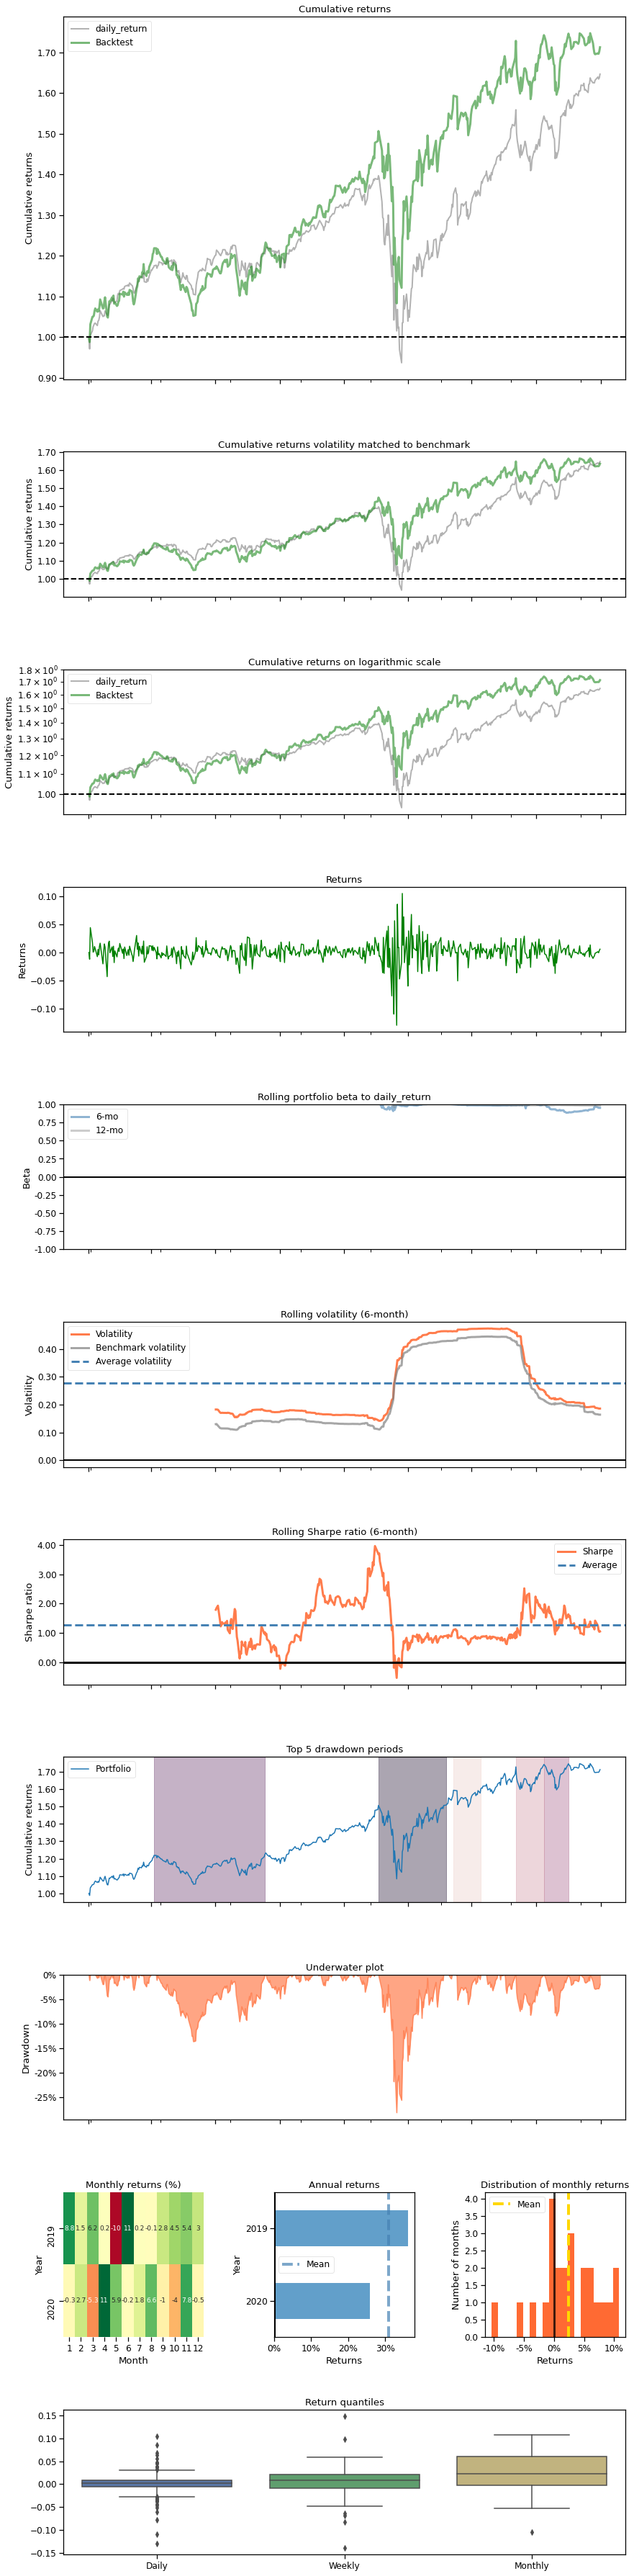

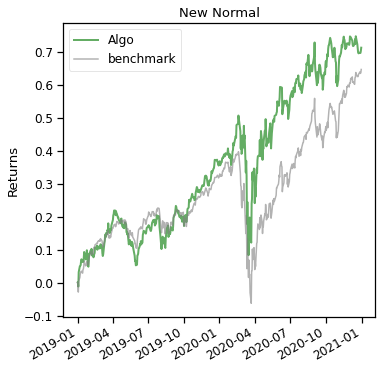

In [37]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

In [38]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_ppo,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:159216.0174362498
Sharpe:  0.9842940394714473
hit end!


In [39]:
df_daily_return

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.012989
2,2019-01-04,0.039770
3,2019-01-07,0.012093
4,2019-01-08,0.009483
...,...,...
500,2020-12-24,-0.002433
501,2020-12-28,0.006143
502,2020-12-29,-0.001825
503,2020-12-30,0.003209


In [40]:
df_actions.head()

,GILD,MMM,NVDA,SRE,TJX
date,,,,,
2019-01-02,0.200000,0.200000,0.200000,0.200000,0.200000
2019-01-03,0.277409,0.330301,0.124749,0.124749,0.142792
2019-01-04,0.297227,0.186859,0.109344,0.109344,0.297227
2019-01-07,0.292506,0.107607,0.107607,0.292506,0.199775
2019-01-08,0.129597,0.129597,0.129597,0.304191,0.307018


In [41]:
df_actions.to_csv('df_actions_ppo_5_3.csv')

In [42]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [43]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.261227
Cumulative returns      0.592160
Annual volatility       0.274316
Sharpe ratio            0.984294
Calmar ratio            0.919195
Stability               0.824042
Max drawdown           -0.284191
Omega ratio             1.218984
Sortino ratio           1.384172
Skew                   -0.509429
Kurtosis               12.470929
Tail ratio              0.940705
Daily value at risk    -0.033489
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,26.123%
Cumulative returns,59.216%
Annual volatility,27.432%
Sharpe ratio,0.98
Calmar ratio,0.92
Stability,0.82
Max drawdown,-28.419%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.42,2020-02-19,2020-03-23,2020-06-05,78
1,13.17,2019-04-05,2019-06-03,2019-10-15,138
2,7.61,2020-10-12,2020-10-30,2020-11-10,22
3,6.96,2020-09-02,2020-09-23,2020-10-12,29
4,6.25,2020-06-05,2020-06-11,2020-07-15,29


Stress Events,mean,min,max
New Normal,0.11%,-11.06%,11.31%


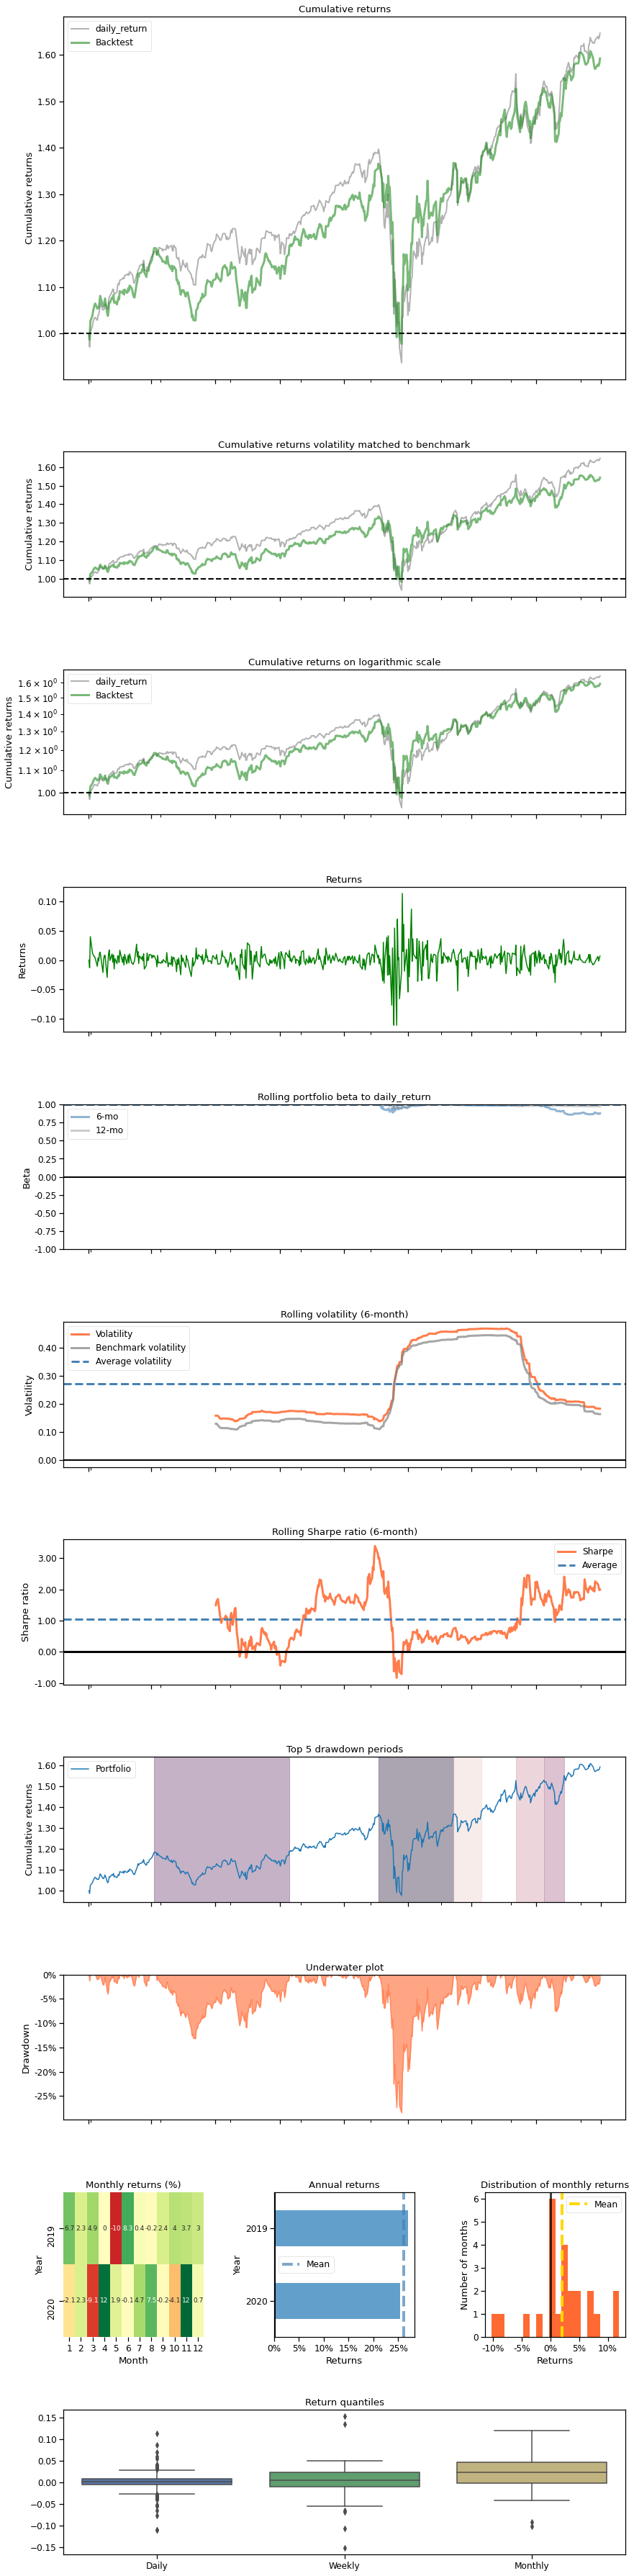

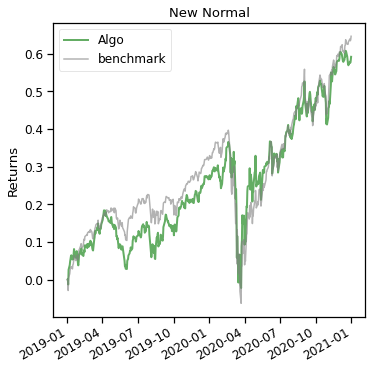

In [44]:
import pyfolio

%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

In [45]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_sac,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:153080.85548724973
Sharpe:  0.9297919260949229
hit end!


In [46]:
df_daily_return

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.007690
2,2019-01-04,0.040117
3,2019-01-07,0.015605
4,2019-01-08,0.001429
...,...,...
500,2020-12-24,-0.003153
501,2020-12-28,0.005608
502,2020-12-29,-0.001981
503,2020-12-30,0.001956


In [47]:
df_actions

,GILD,MMM,NVDA,SRE,TJX
date,,,,,
2019-01-02,0.200000,0.200000,0.200000,0.200000,0.200000
2019-01-03,0.328007,0.139746,0.164007,0.132155,0.236084
2019-01-04,0.323574,0.123991,0.128025,0.123942,0.300468
2019-01-07,0.352563,0.133112,0.157664,0.133867,0.222794
2019-01-08,0.350234,0.137653,0.154527,0.137174,0.220412
...,...,...,...,...,...
2020-12-24,0.342139,0.126055,0.127687,0.126166,0.277953
2020-12-28,0.322718,0.118870,0.118898,0.118878,0.320636
2020-12-29,0.372972,0.138093,0.139460,0.138165,0.211310


In [48]:
df_actions.to_csv('df_actions_sac_5_3.csv')

In [49]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [50]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.236737
Cumulative returns      0.530809
Annual volatility       0.267327
Sharpe ratio            0.929792
Calmar ratio            0.975153
Stability               0.877856
Max drawdown           -0.242769
Omega ratio             1.201982
Sortino ratio           1.300796
Skew                   -0.740209
Kurtosis               10.923789
Tail ratio              0.891159
Daily value at risk    -0.032694
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,23.674%
Cumulative returns,53.081%
Annual volatility,26.733%
Sharpe ratio,0.93
Calmar ratio,0.98
Stability,0.88
Max drawdown,-24.277%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.28,2020-03-04,2020-03-23,2020-05-27,61
1,11.47,2019-04-08,2019-05-31,2019-09-10,112
2,9.44,2020-08-17,2020-10-30,2020-11-24,72
3,6.93,2020-06-08,2020-06-26,2020-07-21,32
4,5.46,2019-09-11,2019-10-02,2019-10-15,25


Stress Events,mean,min,max
New Normal,0.10%,-11.92%,9.16%


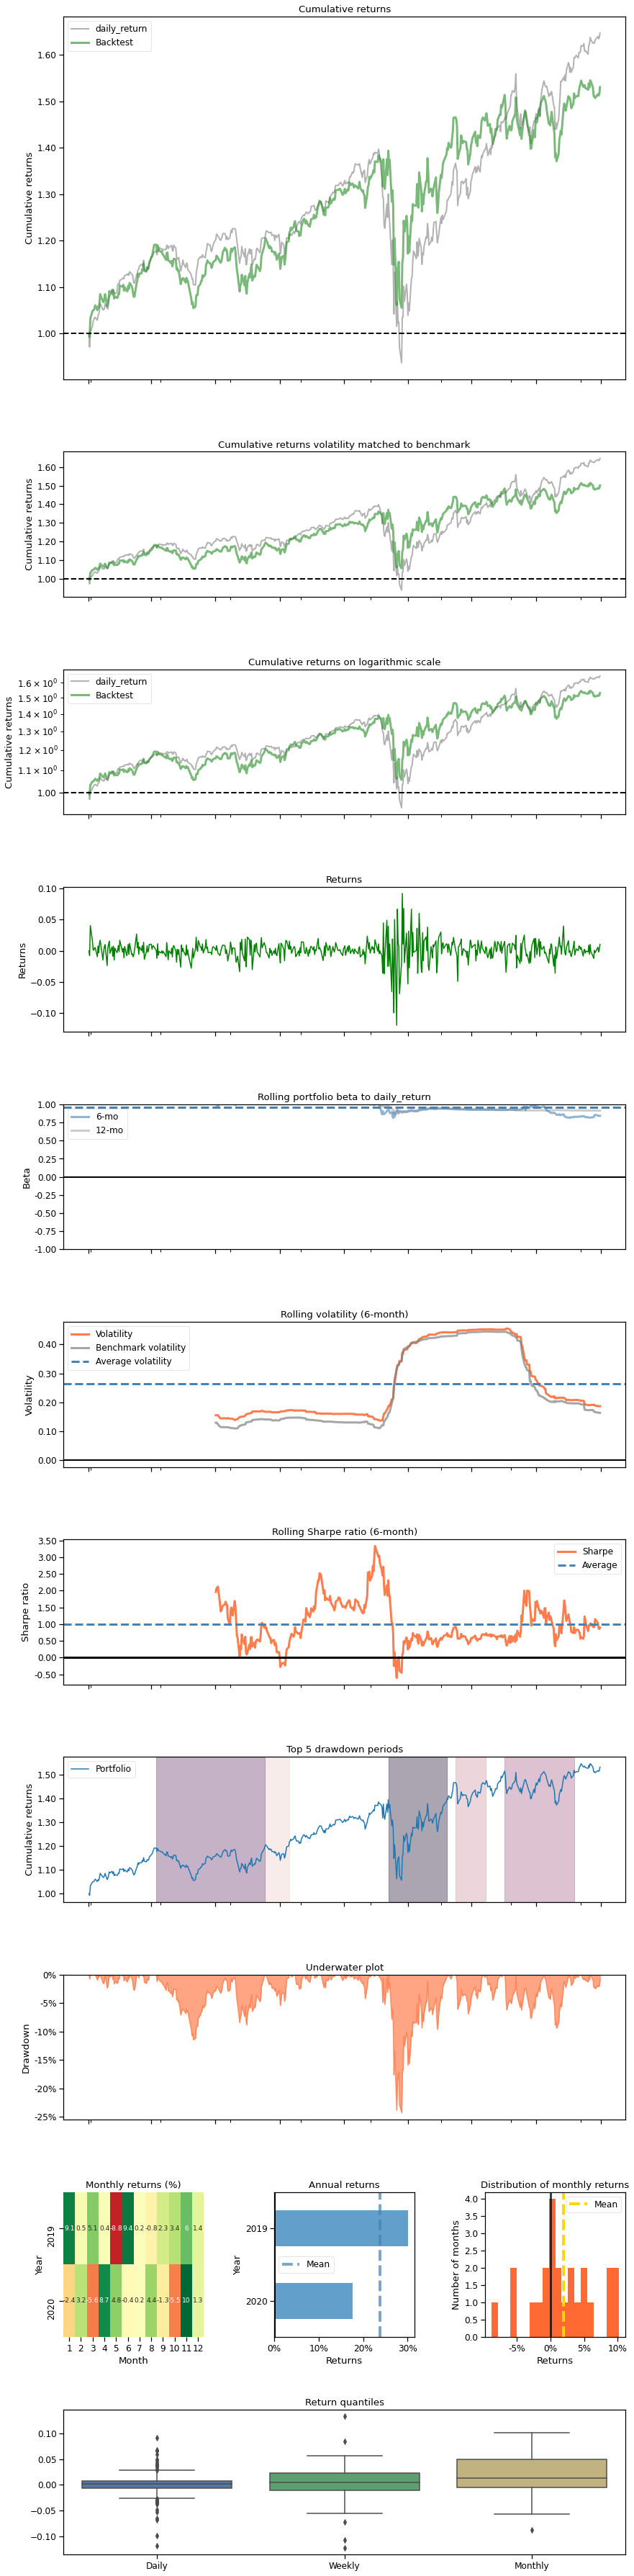

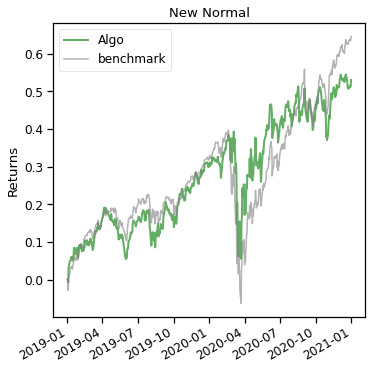

In [51]:
%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)